In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dense, Dropout, Concatenate, GlobalAveragePooling2D, MaxPooling2D, Flatten, Add
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import cv2
import tifffile
import matplotlib.pyplot as plt

In [2]:
excel_file_path = 'Dataset/SNR_CNR/Target_file.xlsx'
base_dataset_dir = 'Dataset/AI images'

# Load the Excel file
xls = pd.ExcelFile(excel_file_path)

images = []  # List to store image data
targets = []  # List to store SNR and CNR as regression targets

shapes = set()
# Define the target size for all images
target_size = (9, 9)  # Target size (width, height)

# Iterate over each sheet in the Excel file
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    print(f"Processing sheet: {sheet_name}")  # Announce the processing of a new sheet
    
    for index, row in df.iterrows():
        tif_path = os.path.join(base_dataset_dir, sheet_name, f"{row['StackNo']}.tif")
        print(f"Current folder: {os.path.join(sheet_name, row['StackNo'])}, Current image number: {row['ImgNum']}")  # Print current processing info

        if not os.path.exists(tif_path):
            print(f"File not found: {tif_path}")
            continue
        
        try:
            with tifffile.TiffFile(tif_path) as tif:
                # Define image_index here to fix the undefined error
                image_index = row['ImgNum'] - 1  
                if image_index < len(tif.pages):
                    img = tif.pages[image_index].asarray()
                    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                    # Normalize the resized image to 0-255
                    min_val = np.min(resized_img)
                    max_val = np.max(resized_img)
                    if max_val > min_val:  # Avoid division by zero
                        normalized_img = (resized_img - min_val) / (max_val - min_val)
                    else:
                        normalized_img = np.zeros_like(resized_img)

                    snr = row['SNR']
                    cnr = row['CNR']
                    
                    # Append the image and targets only if both SNR and CNR are non-negative
                    if snr >= 0 and cnr >= 0:
                        images.append(resized_img)
                        targets.append([snr, cnr])
                        shapes.add(img.shape)
                        print(f"Accessing {row['StackNo']}: ImgNum {row['ImgNum']}, Zero-based index in TIFF: {image_index}, SNR={snr}, CNR={cnr}, Image Shape={img.shape}")
                else:
                    print(f"Image number {row['ImgNum']} out of range for file {tif_path}")
        except Exception as e:
            print(f"Error processing file {tif_path}: {e}")

# Convert lists to numpy arrays for easier manipulation
images_np = np.array(images)
targets_np = np.array(targets)

# Print the number of samples after filtering
print(f"Number of images after filtering: {len(images_np)}")
print(f"Number of targets after filtering: {len(targets_np)}")

# Verify no negative values exist in the targets
negative_count = np.sum((targets_np < 0).any(axis=1))
print(f"Number of targets with negative values: {negative_count}")


Processing sheet: 70Kvp,215mAs,0.5s
Current folder: 70Kvp,215mAs,0.5s\Stack1, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack2, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack3, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack4, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack5, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack6, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack7, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack8, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack9, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack10, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack11, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack12, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack13, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\Stack14, Current image number: 1
Current folder: 70Kvp,215mAs,0.5s\S

In [3]:
targets_np = np.array(targets)

snr_min, snr_max = 0.006215946588903384, 130.9684210526316
cnr_min, cnr_max = 0.131842534, 1291.273676676919

new_min, new_max = 1, 100

# Normalize SNR and CNR 
snr_normalized = (targets_np[:, 0] - snr_min) / (snr_max - snr_min) * (new_max - new_min) + new_min
cnr_normalized = (targets_np[:, 1] - cnr_min) / (cnr_max - cnr_min) * (new_max - new_min) + new_min

# Combine the normalized targets back
targets_normalized = np.column_stack((snr_normalized, cnr_normalized))

print("Normalized targets (range 1-100):")
print(targets_normalized[:5])

Normalized targets (range 1-100):
[[ 1.23338465  2.91648924]
 [ 3.77624065 13.60345042]
 [ 1.78130036  6.28201166]
 [ 7.61085471 18.31341052]
 [ 5.46230193 19.5522902 ]]


In [4]:
images_processed = [img for img in images if isinstance(img, np.ndarray) and img.shape == (9, 9)]
X = np.array([img.reshape(9, 9, 1) for img in images_processed])

targets_processed = [targets_normalized[i] for i, img in enumerate(images) if isinstance(img, np.ndarray) and img.shape == (9, 9)]
y = np.array(targets_processed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (ss_res / ss_tot)

In [9]:
def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), use_bias=False)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)
    x = Concatenate()([x, x1])
    return x

def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), (1, 1), use_bias=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def build_densenet(input_shape=(9, 9, 1), growth_rate=36, blocks=[3, 2], reduction=0.9, dropout_rate=0.30000000000000004, learning_rate=0.00011566756893183716):
    inputs = Input(shape=input_shape)
    x = Conv2D(growth_rate * 2, (3, 3), padding='same')(inputs)
    
    for i, block in enumerate(blocks):
        x = dense_block(x, block, growth_rate)
        if i != len(blocks) - 1:
            x = transition_block(x, reduction)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(2)(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model

model = build_densenet()
model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('snr_cnr1.keras', monitor='val_loss', save_best_only=True, verbose=1)

#fit
history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 9, 9, 72)  │        720 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 72)  │        288 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 9, 9, 72)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 9, 9, 144) │     10,368 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 144) │        576 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 9, 9, 144) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 9, 9, 36)  │     46,656 │ activation_25[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 9, 9, 108) │          0 │ conv2d_24[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 108) │        432 │ concatenate_10[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 9, 9, 108) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 9, 9, 144) │     15,552 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 144) │        576 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 9, 9, 144) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 9, 9, 36)  │     46,656 │ activation_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 9, 9, 144) │          0 │ concatenate_10[0… │
│ (Concatenate)       │                   │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 144) │        576 │ concatenate_11[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 9, 9, 144) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 369,398 (1.41 MB)

 Trainable params: 365,762 (1.40 MB)

 Non-trainable params: 3,636 (14.20 KB)

Epoch 1/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 206.4338 - mean_squared_error: 206.4338 - r_squared: -0.4138
Epoch 1: val_loss improved from inf to 51.54895, saving model to snr_cnr1.keras
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - loss: 206.3689 - mean_squared_error: 206.3689 - r_squared: -0.4133 - val_loss: 51.5490 - val_mean_squared_error: 51.5490 - val_r_squared: 0.6428 - learning_rate: 1.1567e-04
Epoch 2/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 43.5649 - mean_squared_error: 43.5649 - r_squared: 0.7078
Epoch 2: val_loss improved from 51.54895 to 30.30613, saving model to snr_cnr1.keras
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - loss: 43.5580 - mean_squared_error: 43.5580 - r_squared: 0.7079 - val_loss: 30.3061 - val_mean_squared_error: 30.3061 - val_r_squared: 0.7933 - learning_rate: 1.1567e-04
Epoch 3/100
1001/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 26.8288 - mean_squared_error: 26.8288 - r_squared: 0.8105
Epoch 3: val_loss did not imp

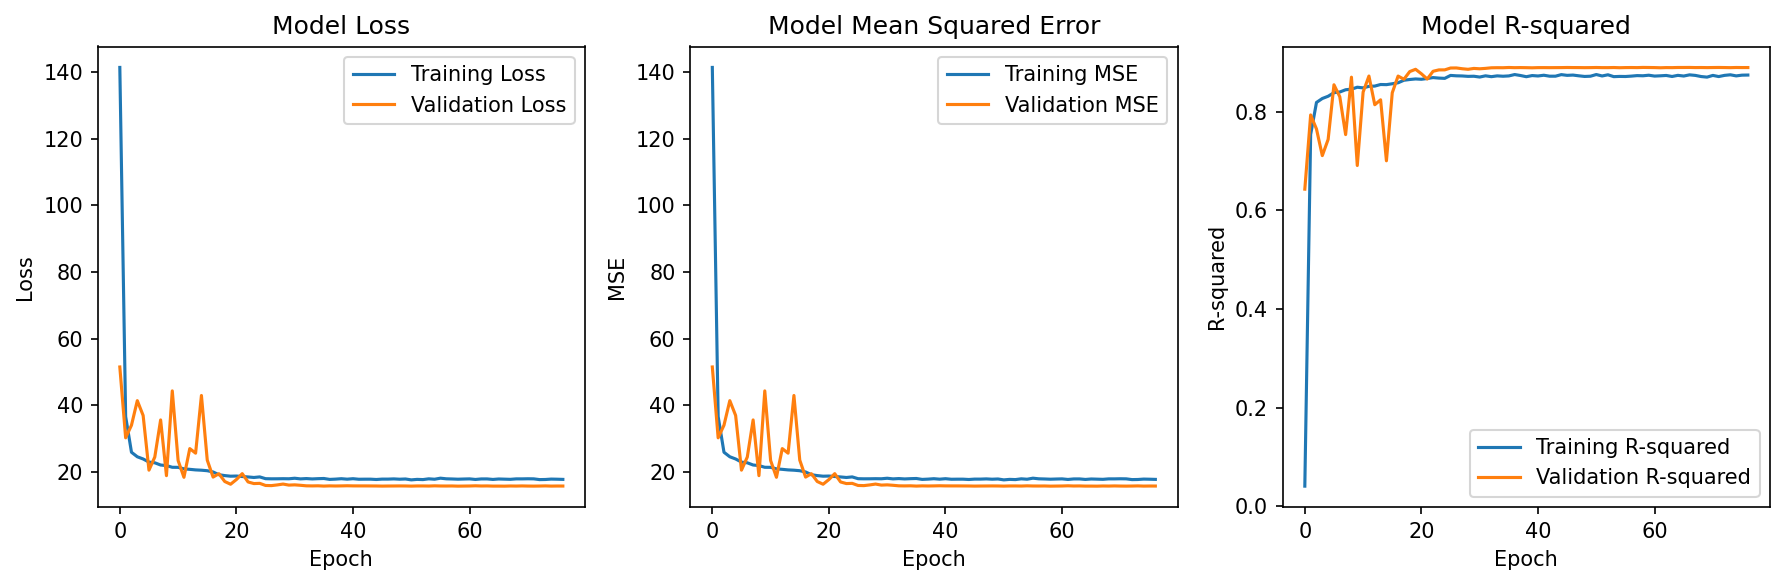

In [56]:

def plot_training_history(history):
    plt.figure(figsize=(12, 4), dpi=150)
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mean_squared_error'], label='Training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['r_squared'], label='Training R-squared')
    plt.plot(history.history['val_r_squared'], label='Validation R-squared')
    plt.title('Model R-squared')
    plt.xlabel('Epoch')
    plt.ylabel('R-squared')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

plot_training_history(history1)


In [69]:
def build_model(hp):
    model = Sequential([
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
               activation='relu',
               input_shape=(9, 9, 1),
               padding='same'),
        MaxPooling2D(2, 2),
        Dropout(rate=hp.Float('dropout_1_rate', min_value=0.0, max_value=0.5, step=0.05)),
        
        Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
               activation='relu',
               padding='same'),
        Dropout(rate=hp.Float('dropout_2_rate', min_value=0.0, max_value=0.5, step=0.05)),
        
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
              activation='relu'),
        Dropout(rate=hp.Float('dropout_3_rate', min_value=0.0, max_value=0.5, step=0.05)),
        Dense(2)
    ])
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=[MeanAbsoluteError(), r_squared])
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_mean_absolute_error', direction='min'),
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_model(best_hps)
print("Best Hyperparameters Found:\n")

# Convolutional Layer 1
print(f"conv_1_filter: {best_hps.get('conv_1_filter')}")
print(f"conv_1_kernel: {best_hps.get('conv_1_kernel')}")

# Dropout 1
print(f"dropout_1_rate: {best_hps.get('dropout_1_rate')}")

# Convolutional Layer 2
print(f"conv_2_filter: {best_hps.get('conv_2_filter')}")
print(f"conv_2_kernel: {best_hps.get('conv_2_kernel')}")

# Dropout 2
print(f"dropout_2_rate: {best_hps.get('dropout_2_rate')}")

# Dense Layer
print(f"dense_units: {best_hps.get('dense_units')}")

# Dropout 3
print(f"dropout_3_rate: {best_hps.get('dropout_3_rate')}")

# Learning Rate
print(f"learning_rate: {best_hps.get('learning_rate')}")


Trial 20 Complete [00h 06m 04s]
val_mean_absolute_error: 5.0938483874003095

Best val_mean_absolute_error So Far: 3.0738371213277182
Total elapsed time: 01h 44m 10s
Best Hyperparameters Found:

conv_1_filter: 48
conv_1_kernel: 5
dropout_1_rate: 0.0
conv_2_filter: 80
conv_2_kernel: 3
dropout_2_rate: 0.35000000000000003
dense_units: 64
dropout_3_rate: 0.25
learning_rate: 0.000596718786458907


In [73]:
model = Sequential([
    Conv2D(filters=best_hps.get('conv_1_filter'),
           kernel_size=best_hps.get('conv_1_kernel'),
           activation='relu',
           input_shape=(9, 9, 1),
           padding='same'),
    MaxPooling2D(2, 2),
    Dropout(rate=best_hps.get('dropout_1_rate')),
    Conv2D(filters=best_hps.get('conv_2_filter'),
           kernel_size=best_hps.get('conv_2_kernel'),
           activation='relu',
           padding='same'),
    Dropout(rate=best_hps.get('dropout_2_rate')),
    Flatten(),
    Dense(units=best_hps.get('dense_units'), activation='relu'),
    Dropout(rate=best_hps.get('dropout_3_rate')),
    Dense(2)  
])

model.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
              loss='mean_squared_error',
              metrics=[MeanSquaredError(), r_squared])

model.summary()

history6 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 9, 9, 48)       │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 80)       │        34,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,002 (460.95 KB)

 Trainable params: 118,002 (460.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 508.5828 - mean_squared_error: 508.5828 - r_squared: -2.4827 - val_loss: 44.6166 - val_mean_squared_error: 44.6166 - val_r_squared: 0.6949
Epoch 2/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 61.3029 - mean_squared_error: 61.3029 - r_squared: 0.5645 - val_loss: 40.6935 - val_mean_squared_error: 40.6935 - val_r_squared: 0.7200
Epoch 3/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 55.1360 - mean_squared_error: 55.1360 - r_squared: 0.6093 - val_loss: 39.8121 - val_mean_squared_error: 39.8121 - val_r_squared: 0.7286
Epoch 4/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 50.4186 - mean_squared_error: 50.4186 - r_squared: 0.6453 - val_loss: 34.4079 - val_mean_squared_error: 34.4079 - val_r_squared: 0.7629
Epoch 5/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 49.5302 - mean_squared_error: 49.5302 - r_squared: 0.6506 - val_loss: 31.6555 - val_mean_squared_error: 31.6555 - val_r_squared: 0.7828
E

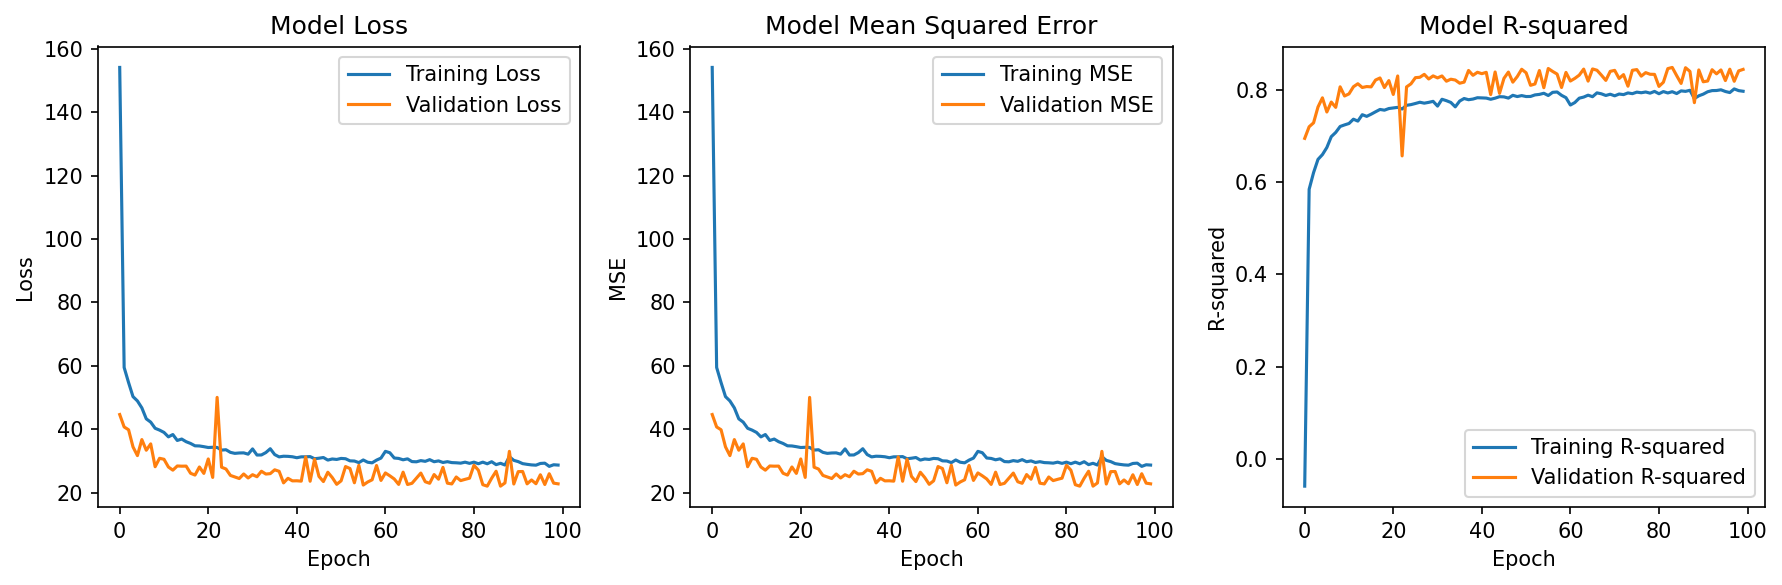

In [74]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4), dpi=150)
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['mean_squared_error'], label='Training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['r_squared'], label='Training R-squared')
    plt.plot(history.history['val_r_squared'], label='Validation R-squared')
    plt.title('Model R-squared')
    plt.xlabel('Epoch')
    plt.ylabel('R-squared')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

plot_training_history(history6)


In [77]:
histories = [history1, history2, history3, history4, history5, history6]

def get_best_results(history):
    best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
    best_val_loss = min(history.history['val_loss'])
    best_mse = min(history.history['val_mean_squared_error'])
    best_r_squared = max(history.history['val_r_squared'])
    return best_epoch, best_val_loss, best_mse, best_r_squared

for i, history in enumerate(histories):
    best_epoch, best_val_loss, best_mse, best_r_squared = get_best_results(history)
    print(f"The best result for history{i+1}:")
    print(f"  - Epoch: {best_epoch+1}")
    print(f"  - Validation Loss: {best_val_loss:.4f}")
    print(f"  - Mean Squared Error (MSE): {best_mse:.4f}")
    print(f"  - R-squared: {best_r_squared:.4f}")
    print()


The best result for history1:
  - Epoch: 67
  - Validation Loss: 15.8104
  - Mean Squared Error (MSE): 15.8104
  - R-squared: 0.8896

The best result for history2:
  - Epoch: 64
  - Validation Loss: 28.4053
  - Mean Squared Error (MSE): 28.4053
  - R-squared: 0.8074

The best result for history3:
  - Epoch: 25
  - Validation Loss: 20.6225
  - Mean Squared Error (MSE): 20.6225
  - R-squared: 0.8572

The best result for history4:
  - Epoch: 51
  - Validation Loss: 15.9658
  - Mean Squared Error (MSE): 15.9658
  - R-squared: 0.8886

The best result for history5:
  - Epoch: 43
  - Validation Loss: 15.3276
  - Mean Squared Error (MSE): 15.3276
  - R-squared: 0.8932

The best result for history6:
  - Epoch: 87
  - Validation Loss: 22.0120
  - Mean Squared Error (MSE): 22.0120
  - R-squared: 0.8487



In [10]:
def build_rnn(input_shape=(9, 9, 1), dropout_rate1=0.5, dropout_rate2=0.3, learning_rate=6.0055255962533226e-05):
    inputs = Input(shape=input_shape)
    x = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)  # Reshape to (batch_size, timesteps, features)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(dropout_rate1)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(dropout_rate2)(x)
    x = LSTM(128)(x)
    x = Dropout(dropout_rate2)(x)
    x = Dense(2)(x)  # No activation function specified, for regression output
    
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model


model = build_rnn()
model.summary()

# callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# fit
history2 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 9, 9, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 9, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 9, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 9, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,082 (1.27 MB)

 Trainable params: 334,082 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 203.8943 - mean_squared_error: 203.8943 - r_squared: -0.3528 - val_loss: 121.8082 - val_mean_squared_error: 121.8082 - val_r_squared: 0.1927 - learning_rate: 6.0055e-05
Epoch 2/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 111.4551 - mean_squared_error: 111.4551 - r_squared: 0.2560 - val_loss: 73.9068 - val_mean_squared_error: 73.9068 - val_r_squared: 0.5227 - learning_rate: 6.0055e-05
Epoch 3/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 70.0186 - mean_squared_error: 70.0186 - r_squared: 0.5268 - val_loss: 59.0055 - val_mean_squared_error: 59.0055 - val_r_squared: 0.6178 - learning_rate: 6.0055e-05
Epoch 4/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 62.8032 - mean_squared_error: 62.8032 - r_squared: 0.5933 - val_loss: 51.8913 - val_mean_squared_error: 51.8913 - val_r_squared: 0.6609 - learning_rate: 6.0055e-05
Epoch 5/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 54.4798 - mean_

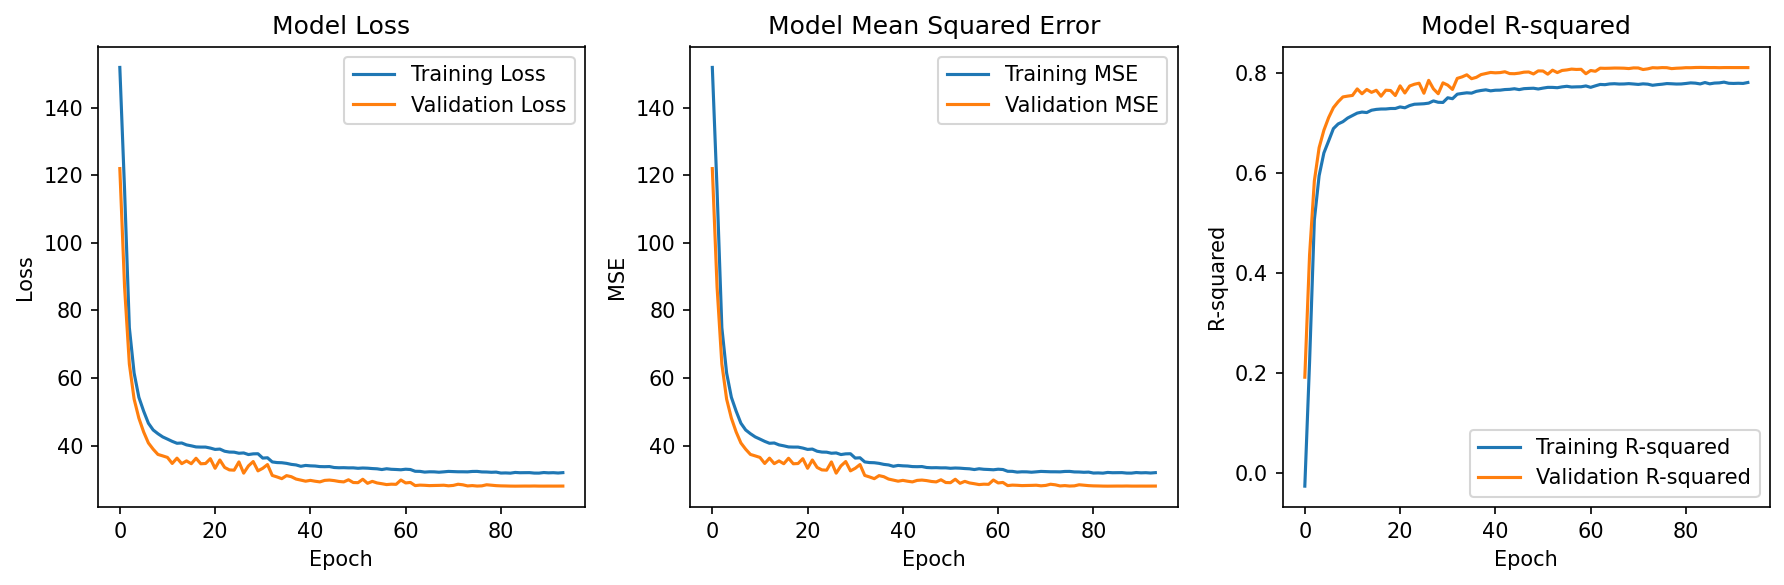

In [23]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4), dpi=150)
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['mean_squared_error'], label='Training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['r_squared'], label='Training R-squared')
    plt.plot(history.history['val_r_squared'], label='Validation R-squared')
    plt.title('Model R-squared')
    plt.xlabel('Epoch')
    plt.ylabel('R-squared')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [11]:
class PatchExtract(Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dim = self.patch_size * self.patch_size * images.shape[-1]
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_dim])
        return patches

def transformer_block(x, head_size, num_heads, ff_dim, dropout=0):
    attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    attn_output = Add()([x, attn_output])
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output)

    ffn_output = Dense(ff_dim, activation='relu')(attn_output)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    ffn_output = Add()([attn_output, ffn_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
    return ffn_output

def vision_transformer(input_shape=(9, 9, 1), patch_size=3, num_layers=4, head_size=64, num_heads=4, ff_dim=128, dropout_rate=0.1, learning_rate=0.00011566756893183716):
    inputs = Input(shape=input_shape)
    
    patches = PatchExtract(patch_size=patch_size)(inputs)
    x = Dense(units=head_size)(patches)
    
    for _ in range(num_layers):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout_rate)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(2)(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model



input_shape = (9, 9, 1)  
model = vision_transformer(input_shape=input_shape)
model.summary()

# cbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('snr_cnr_transformer.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extract       │ (None, None, 9)   │          0 │ input_layer_4[0]… │
│ (PatchExtract)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 64)  │        640 │ patch_extract[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ dense_3[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ dense_3[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, None, 64)  │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, None, 64)  │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 333,570 (1.27 MB)

 Trainable params: 333,570 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 169.2460 - mean_squared_error: 169.2460 - r_squared: -0.1249
Epoch 1: val_loss improved from inf to 122.13685, saving model to snr_cnr_transformer.keras
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 169.2163 - mean_squared_error: 169.2163 - r_squared: -0.1247 - val_loss: 122.1368 - val_mean_squared_error: 122.1368 - val_r_squared: 0.1844 - learning_rate: 1.1567e-04
Epoch 2/100
1000/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 91.3410 - mean_squared_error: 91.3410 - r_squared: 0.3994
Epoch 2: val_loss improved from 122.13685 to 105.24879, saving model to snr_cnr_transformer.keras
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 91.3095 - mean_squared_error: 91.3095 - r_squared: 0.3996 - val_loss: 105.2488 - val_mean_squared_error: 105.2488 - val_r_squared: 0.2786 - learning_rate: 1.1567e-04
Epoch 3/100
 999/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 59.5033 - mean_squared_error: 59.5033 - r_squared: 0.6046


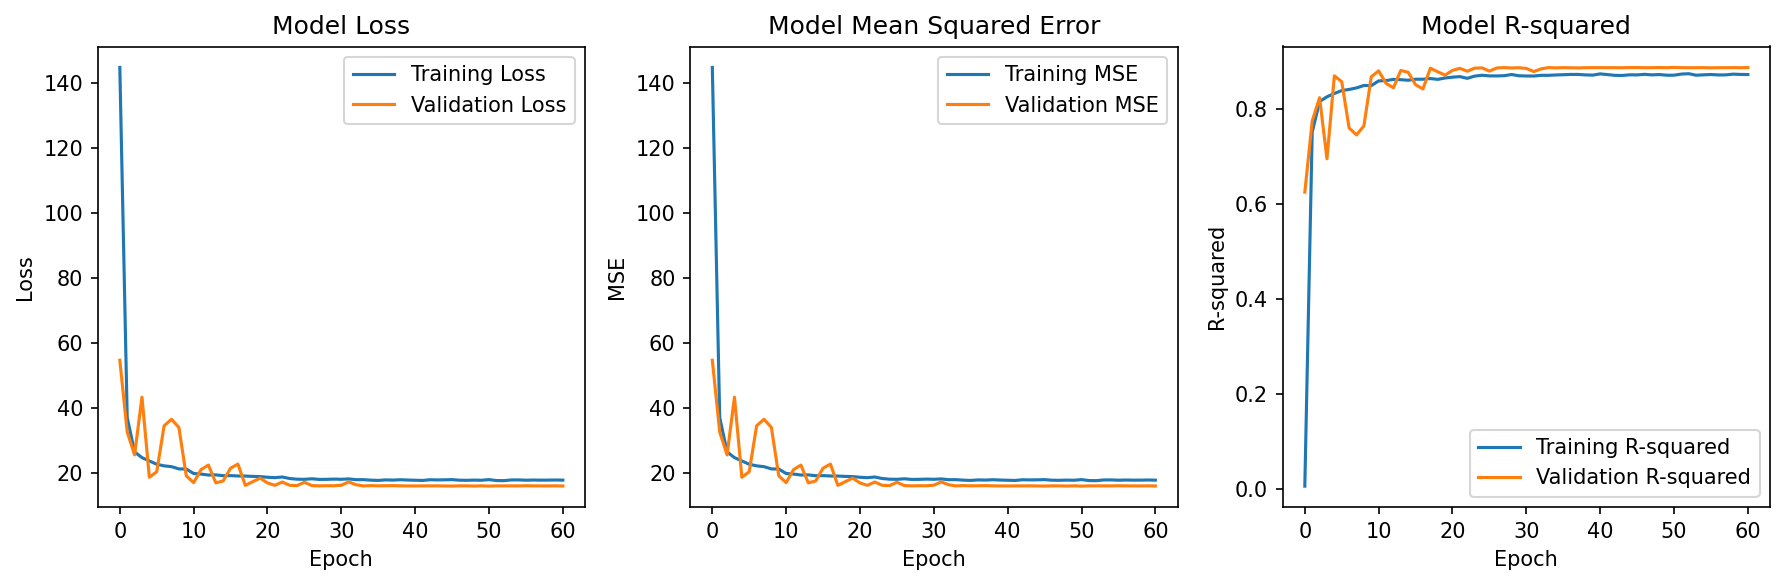

In [35]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4), dpi=150)
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['mean_squared_error'], label='Training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['r_squared'], label='Training R-squared')
    plt.plot(history.history['val_r_squared'], label='Validation R-squared')
    plt.title('Model R-squared')
    plt.xlabel('Epoch')
    plt.ylabel('R-squared')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

plot_training_history(history4)


In [35]:

# SNR and CNR ranges
snr_min, snr_max = 0.006215946588903384, 130.9684210526316
cnr_min, cnr_max = 0.131842534, 1291.273676676919

# Desired range
new_min, new_max = 1, 100

# Normalize SNR and CNR to the range [1, 100]
snr_normalized = (targets_np[:, 0] - snr_min) / (snr_max - snr_min) * (new_max - new_min) + new_min
cnr_normalized = (targets_np[:, 1] - cnr_min) / (cnr_max - cnr_min) * (new_max - new_min) * new_min

# Combine the normalized targets back
targets_normalized = np.column_stack((snr_normalized, cnr_normalized))

print("Normalized targets (range 1-100):")
print(targets_normalized[:5])



model = load_model('snr_cnr.keras', custom_objects={'r_squared': r_squared})

# Predict Xtest
y_pred_normalized = model.predict(X_test)

# Re-normalize 
y_pred = np.zeros_like(y_pred_normalized)
y_pred[:, 0] = (y_pred_normalized[:, 0] - new_min) / (new_max - new_min) * (snr_max - snr_min) + snr_min
y_pred[:, 1] = (y_pred_normalized[:, 1] - new_min) / (new_max - new_min) * (cnr_max - cnr_min) + cnr_min

y_test_actual = np.zeros_like(y_test)
y_test_actual[:, 0] = (y_test[:, 0] - new_min) / (new_max - new_min) * (snr_max - snr_min) + snr_min
y_test_actual[:, 1] = (y_test[:, 1] - new_min) / (new_max - new_min) * (cnr_max - cnr_min) + cnr_min

comparison = np.concatenate((y_test_actual, y_pred), axis=1)
comparison_df = pd.DataFrame(comparison, columns=['Actual SNR', 'Actual CNR', 'Predicted SNR', 'Predicted CNR'])

print(comparison_df.head(10))

# evaluate
evaluation = model.evaluate(X_test, y_test)
print(f"Evaluation results: {evaluation}")


Normalized targets (range 1-100):
[[ 1.23338465  1.91648924]
 [ 3.77624065 12.60345042]
 [ 1.78130036  5.28201166]
 [ 7.61085471 17.31341052]
 [ 5.46230193 18.5522902 ]]
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
   Actual SNR  Actual CNR  Predicted SNR  Predicted CNR
0    4.375533  392.191241       6.855090     389.338684
1    8.340762  397.528431       6.508611     352.603210
2    7.019139  334.072344       6.251725     315.153992
3    6.150285   62.300012       3.854891      60.680038
4   48.111524  104.665972      47.704704     109.431854
5   29.778062   95.082090      33.035698     140.077652
6    8.594831  206.628114      10.584357     216.143768
7    8.993099  281.405326       9.246137     266.116608
8    5.109456  563.987713       5.010404     513.748962
9    4.455710   71.344972       4.934244      66.831230
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 15.5774 - mean_squared_error: 15.5774 - r_squared: 0.8924
Evaluation results: [15.805885314941406, 15.805885314941406, 0.889

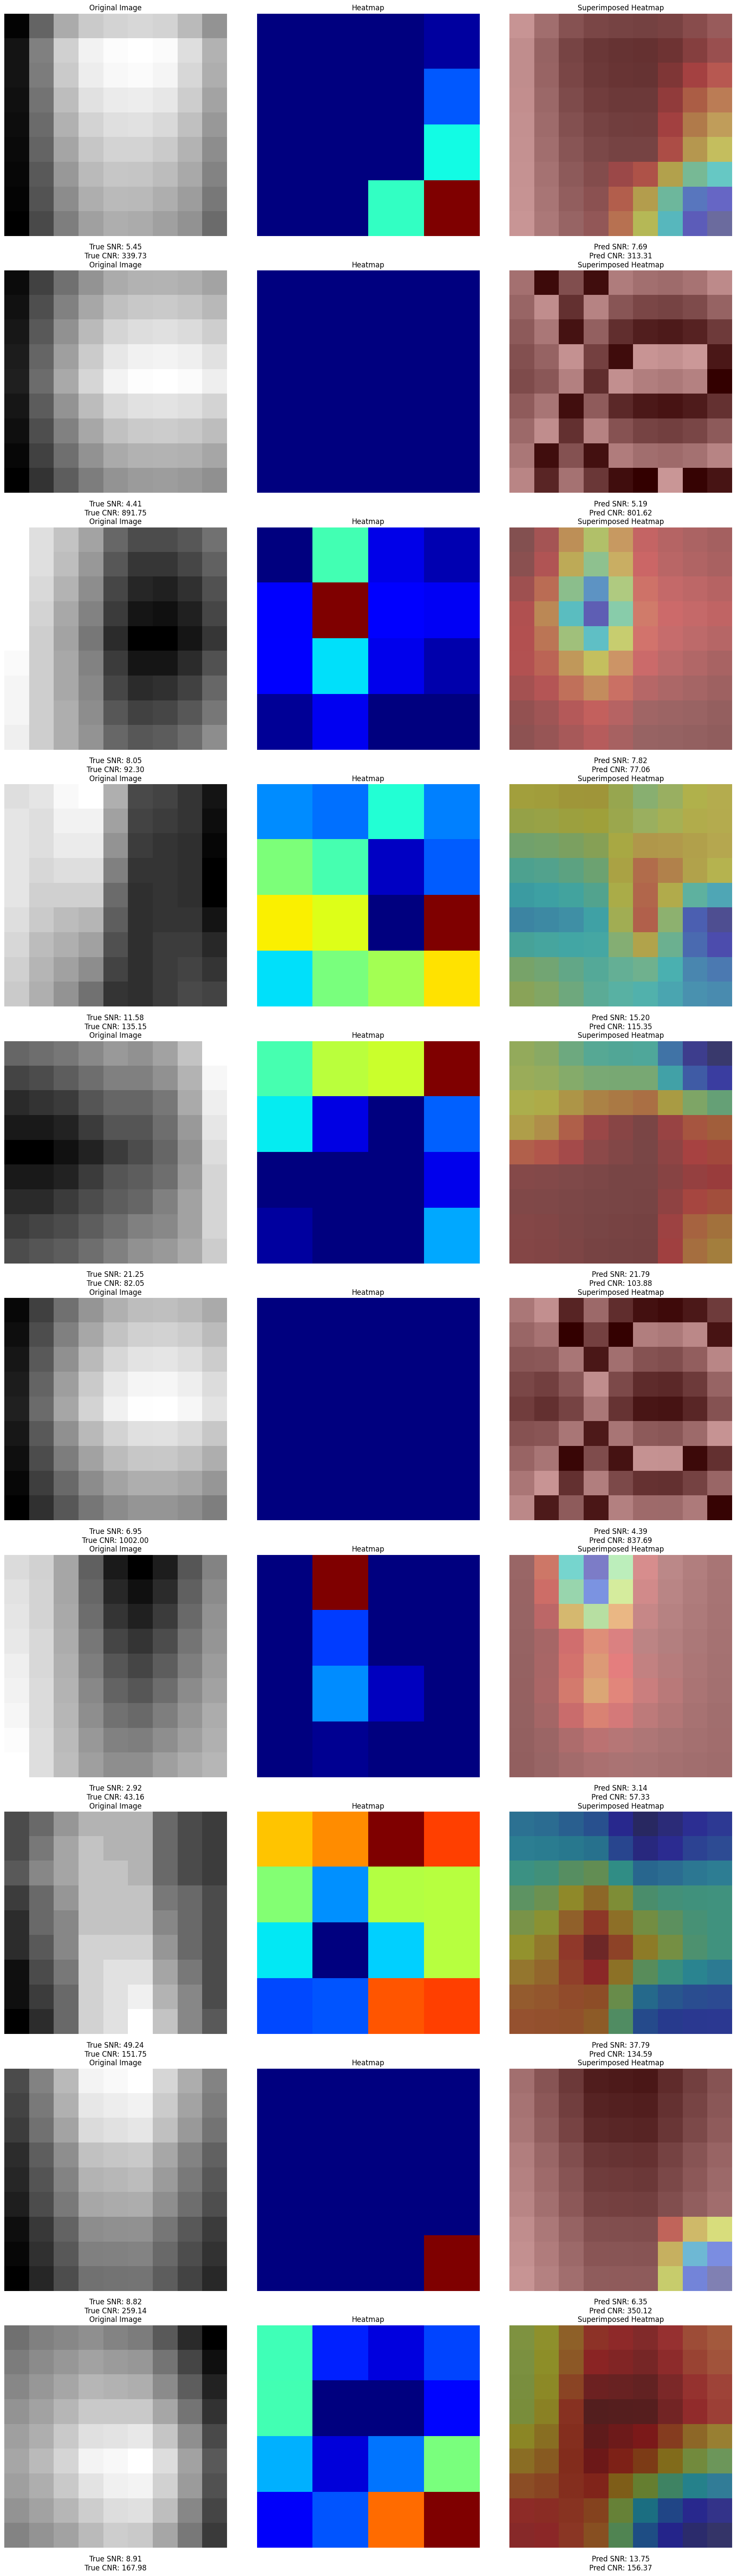

In [36]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise Exception("No convolution layer found")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=0):
    # Create a model that maps the input image to the activations of the last conv layer and the output predictions
    grad_model = tf.keras.models.Model(inputs=model.inputs, 
                                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_image_heatmap(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_rgb = np.repeat(img[..., np.newaxis], 3, axis=2)
    img_rgb = np.uint8(255 * img_rgb)
    superimposed_img = heatmap * 0.4 + img_rgb * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    return superimposed_img

# Randomly select 10 indices from the test set
random_indices = random.sample(range(len(X_test)), 10)

# Plotting
fig, axs = plt.subplots(10, 3, figsize=(18, 60)) 

for i, idx in enumerate(random_indices):
    img_array = X_test[idx:idx+1] 
    original_img = img_array[0].reshape(9, 9) 

    # heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=0)

    # impose heatmap
    superimposed_img = superimpose_image_heatmap(original_img, heatmap)


    true_value = y_test_actual[idx]
    pred_value = y_pred[idx]

    true_snr, true_cnr = true_value
    pred_snr, pred_cnr = pred_value

    axs[i, 0].text(0.5, -0.1, f'True SNR: {true_snr:.2f}\nTrue CNR: {true_cnr:.2f}', fontsize=12, ha='center', transform=axs[i, 0].transAxes)
    axs[i, 2].text(0.5, -0.1, f'Pred SNR: {pred_snr:.2f}\nPred CNR: {pred_cnr:.2f}', fontsize=12, ha='center', transform=axs[i, 2].transAxes)

    axs[i, 0].imshow(original_img, cmap='gray')
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(heatmap, cmap='jet')
    axs[i, 1].set_title('Heatmap')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(superimposed_img)
    axs[i, 2].set_title('Superimposed Heatmap')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()